In [2]:
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import momepy
import libpysal
import osmnx
import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram
from shapely.geometry import Point
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier


In [36]:
buildings = gpd.read_file("buildings.gpkg", layer='buildings')
print(buildings.columns)
streets = gpd.read_file("streets.gpkg", layer='streets')
print(streets.columns)

Index(['OBJECTID', 'BLDG_NUM', 'BLDG_TYPE', 'BLDG_CH', 'NUM_FLOORS',
       'NUM_ENTR', 'NUM_APTS_C', 'layer', 'STRT_CODE1', 'StreetName',
       'STRT_CODE2', 'StreetNa_1', 'Shape_Leng', 'Shape_Length', 'Shape_Area',
       'building_height', 'floor_area', 'volume', 'form_factor', 'perimeter',
       'shape_index', 'circular_compactness', 'square_compactness',
       'weighted_axis_compactness', 'convexity', 'courtyard_area',
       'courtyard_index', 'corners', 'fractal_dimension', 'facade_ratio',
       'orientation', 'longest_axis_length', 'equivalent_rectangular_index',
       'elongation', 'linearity', 'rectangularity', 'squareness',
       'shared_walls_length', 'alignment', 'adjacency',
       'mean_interbuilding_distance', 'neighbour_distance', 'courtyards_num',
       'cell_orientation', 'num_of_neighbours', 'geometry'],
      dtype='object')
Index(['length', 'from', 'to', 'orientation', 'longest_axis_length',
       'compactness_weighted_axis', 'linearity', 'alignment', 'cel

In [ ]:
def summarize_gdf(gdf):
    """
    Function to output useful statistics about a GeoDataFrame in a DataFrame format.
    
    Parameters:
    gdf (GeoDataFrame): A GeoPandas GeoDataFrame to summarize.
    
    Returns:
    DataFrame: A DataFrame where rows are the original columns and columns are statistics like mean, variance, etc.
    """
    # Select only numeric columns (we exclude geometry for this purpose)
    numeric_gdf = gdf.select_dtypes(include=['float64', 'int64'])

    # Calculate key statistics
    summary_df = pd.DataFrame({
        'Mean': numeric_gdf.mean(),
        'Variance': numeric_gdf.var(),
        'Standard Deviation': numeric_gdf.std(),
        'Min': numeric_gdf.min(),
        '25th Percentile': numeric_gdf.quantile(0.25),
        'Median (50th Percentile)': numeric_gdf.median(),
        '75th Percentile': numeric_gdf.quantile(0.75),
        'Max': numeric_gdf.max(),
        'Missing Values': numeric_gdf.isna().sum(),
        'Missing Percentage': (numeric_gdf.isna().sum() / len(gdf)) * 100
    })
    
    return summary_df


Finding leading metrics for group: 1


C:\Users\david\AppData\Local\Temp\ipykernel_15052\689628293.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_metrics.values, y=sorted_metrics.index, palette="Blues_d")


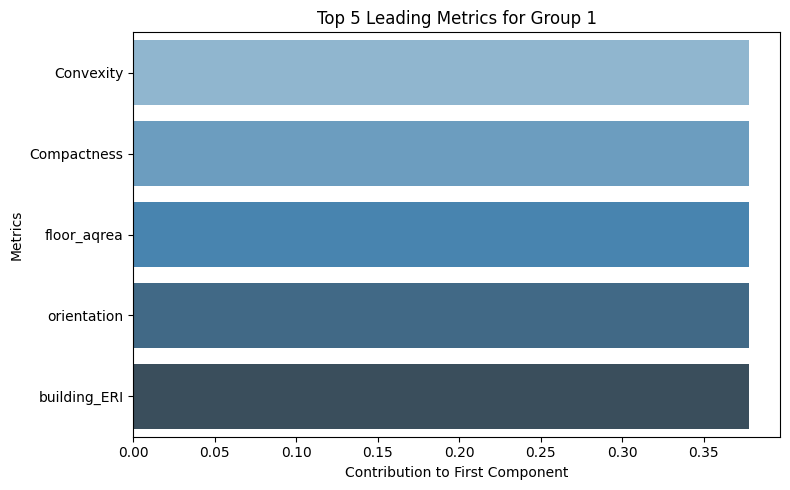


Finding leading metrics for group: 2


C:\Users\david\AppData\Local\Temp\ipykernel_15052\689628293.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_metrics.values, y=sorted_metrics.index, palette="Blues_d")


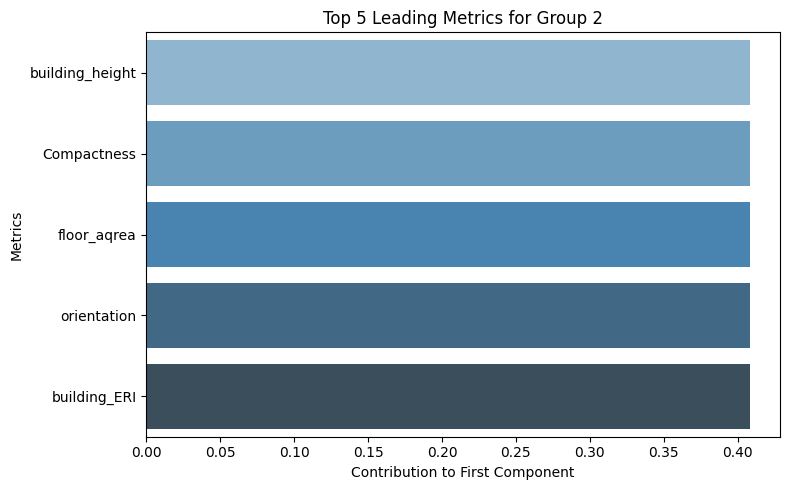

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def find_group_leading_metrics(gdf, classification_column=None, n_components=2):
    group_leading_metrics = {}

    # Standardize the features
    scaler = StandardScaler()

    if classification_column is None:
        print("\nFinding leading metrics for the entire dataset")

        # Drop the geometry column
        features = gdf.drop(columns=['geometry'])

        # Standardize the data
        scaled_features = scaler.fit_transform(features)

        # Apply PCA
        pca = PCA(n_components=n_components)
        pca.fit(scaled_features)

        # Get the principal components
        components = pca.components_

        # Create a DataFrame of components with feature names
        leading_metrics = pd.DataFrame(components, columns=features.columns)

        # Sort metrics by their absolute contribution to the first component
        sorted_metrics = leading_metrics.iloc[0].abs().sort_values(ascending=False).head(5)

        # Plot the top 5 metrics for the first component
        plt.figure(figsize=(8, 5))
        sns.barplot(x=sorted_metrics.values, y=sorted_metrics.index, palette="Blues_d")
        plt.title("Top 5 Leading Metrics for the First Component")
        plt.xlabel("Contribution to First Component")
        plt.ylabel("Metrics")
        plt.tight_layout()
        plt.show()

        # Store the top metrics
        group_leading_metrics['all_data'] = sorted_metrics

    else:
        # Group by classification
        for group, group_data in gdf.groupby(classification_column):
            print(f"\nFinding leading metrics for group: {group}")

            # Drop the classification and geometry columns
            group_features = group_data.drop(columns=[classification_column, 'geometry'])

            # Standardize the group-specific data
            scaled_features = scaler.fit_transform(group_features)

            # Apply PCA
            pca = PCA(n_components=n_components)
            pca.fit(scaled_features)

            # Get the principal components
            components = pca.components_

            # Create a DataFrame of components with feature names
            leading_metrics = pd.DataFrame(components, columns=group_features.columns)

            # Sort metrics by their absolute contribution to the first component
            sorted_metrics = leading_metrics.iloc[0].abs().sort_values(ascending=False).head(5)

            # Plot the top 5 metrics for the first component
            plt.figure(figsize=(8, 5))
            sns.barplot(x=sorted_metrics.values, y=sorted_metrics.index, palette="Blues_d")
            plt.title(f"Top 5 Leading Metrics for Group {group}")
            plt.xlabel("Contribution to First Component")
            plt.ylabel("Metrics")
            plt.tight_layout()
            plt.show()

            # Store the top metrics for this group
            group_leading_metrics[group] = sorted_metrics

    return group_leading_metrics


data = {
    'building_height': [10, 12, 8, 15],
    'Convexity': [5, 9, 2, 2],
    'Compactness': [4, 33, 2, 11],
    'floor_aqrea': [33, 100, 200, 2],
    'orientation': [200, 250, 20, 10],
    'building_ERI': [100, 150, 120, 130],
    'building_area': [200, 250, 180, 300],
    'area_classification': ['1', '1', '2', '2'],
    'geometry': [Point(1, 2), Point(2, 3), Point(3, 4), Point(4, 5)]
}

gdf = gpd.GeoDataFrame(data, geometry='geometry')
classification_column = 'area_classification'
leading_metrics_per_group = find_group_leading_metrics(gdf, classification_column, n_components=1)

# Display the results

In [9]:


def find_overall_leading_metrics(gdf, classification_column):
    # Drop the classification and geometry columns for feature selection
    features = gdf.drop(columns=[classification_column, 'geometry'])
    target = gdf[classification_column]

    # Standardize the features (optional, but often helpful)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Train a Random Forest model on the whole data
    model = RandomForestClassifier(random_state=42)
    model.fit(scaled_features, target)

    # Extract and sort feature importances
    feature_importances = pd.Series(model.feature_importances_, index=features.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    # Print the leading metrics
    print("Overall leading metrics for classification:")
    print(feature_importances.head(10))  # Top 10 most important metrics

    return feature_importances


classification_column = 'area_classification'
top_metrics_per_group = find_overall_leading_metrics(gdf, classification_column)

Overall leading metrics for classification:
Convexity          0.200000
orientation        0.172549
building_height    0.168627
building_ERI       0.129412
building_area      0.117647
Compactness        0.105882
floor_aqrea        0.105882
dtype: float64


In [33]:
# print(buildings.columns)
columns_to_drop = ['OBJECTID', 'BLDG_NUM', 'BLDG_TYPE', 'BLDG_CH', 'NUM_FLOORS',
                   'NUM_ENTR', 'NUM_APTS_C', 'layer', 'STRT_CODE1', 'StreetName',
                   'STRT_CODE2', 'StreetNa_1']
nan_columns = buildings_cleaned.isna().sum()

# Filter and print only the columns that have NaN values
nan_columns_with_values = nan_columns[nan_columns > 0]
print(nan_columns_with_values)
# Drop the columns from the buildings GeoDataFrame
buildings_cleaned = buildings.drop(columns=columns_to_drop)
# print(buildings_cleaned.columns)
# find_group_leading_metrics(buildings_cleaned, n_components = 1)

Shape_Leng        1
linearity     34629
squareness        8
dtype: int64


C:\Users\david\AppData\Local\Temp\ipykernel_15052\2323387612.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Mean', data=metrics_summary, palette='Blues_d')


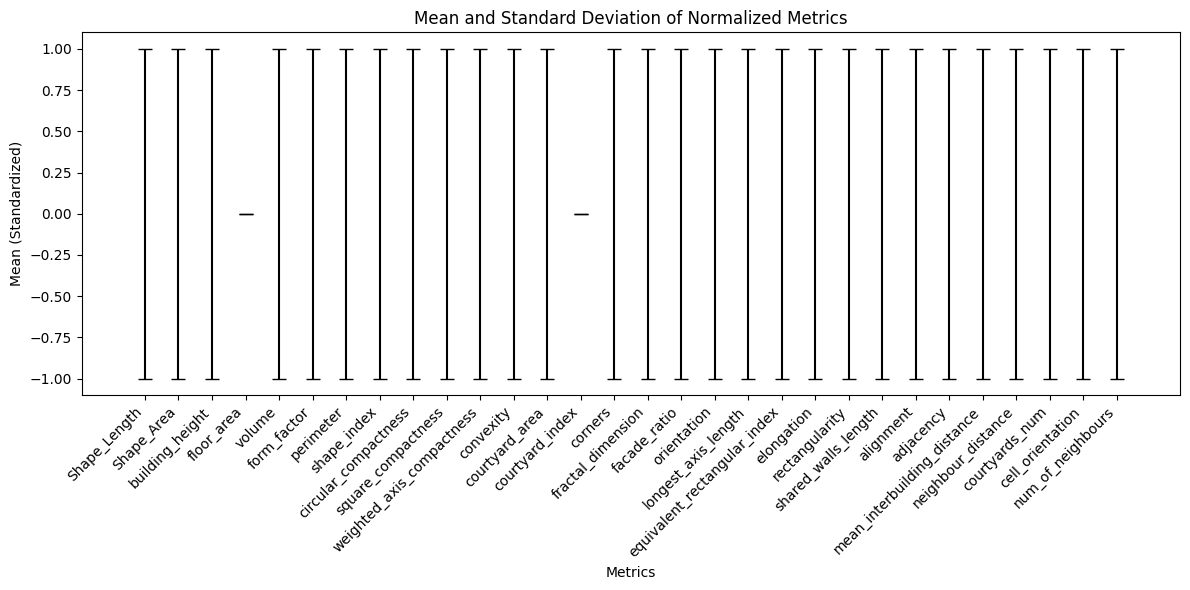

In [24]:
from sklearn.preprocessing import StandardScaler
numeric_columns = buildings_cleaned.select_dtypes(include=['float64', 'int64'])

# Standardize the data (normalize to mean=0, std=1)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numeric_columns)

# Calculate the mean and standard deviation for each metric
means = np.mean(normalized_data, axis=0)
std_devs = np.std(normalized_data, axis=0)

# Create a DataFrame for plotting
metrics_summary = pd.DataFrame({
    'Metric': numeric_columns.columns,
    'Mean': means,
    'Standard Deviation': std_devs
})

# Plot the means with error bars representing the standard deviation
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Mean', data=metrics_summary, palette='Blues_d')

# Add error bars for standard deviation
plt.errorbar(x=metrics_summary['Metric'], y=metrics_summary['Mean'], 
             yerr=metrics_summary['Standard Deviation'], fmt='none', c='black', capsize=5)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Mean and Standard Deviation of Normalized Metrics')
plt.xlabel('Metrics')
plt.ylabel('Mean (Standardized)')

plt.tight_layout()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_15052\1832690491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Mean', data=metrics_summary_raw, palette='Blues_d')


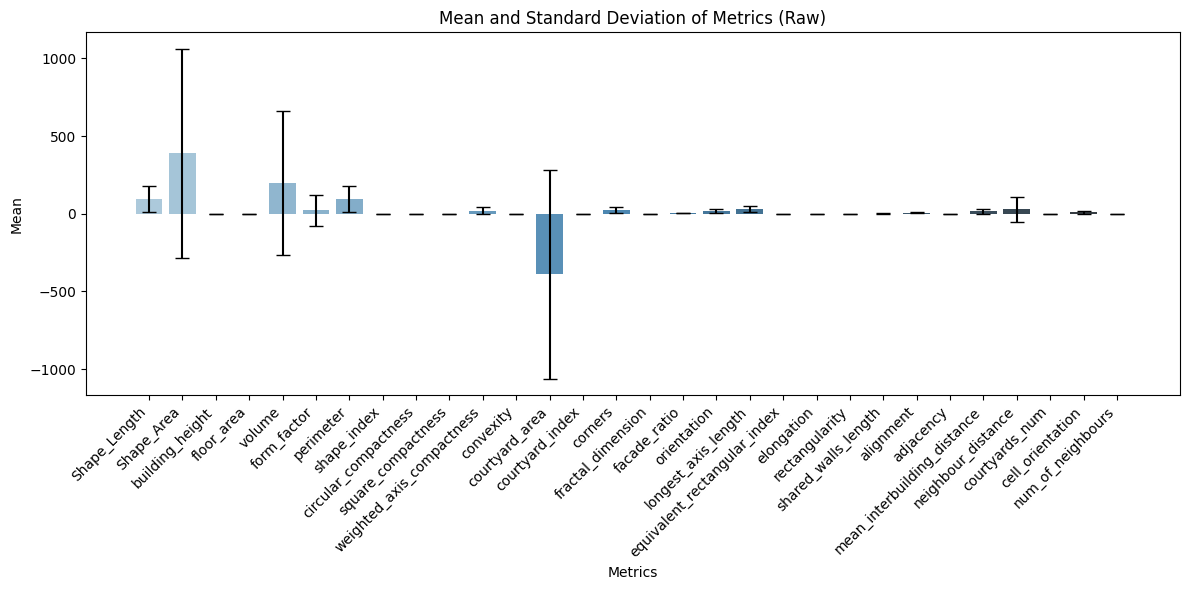

In [25]:
# Select numeric columns (excluding geometry) from buildings_cleaned
numeric_columns = buildings_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculate the mean and standard deviation for each metric
means_raw = numeric_columns.mean()
std_devs_raw = numeric_columns.std()

# Create a DataFrame for plotting
metrics_summary_raw = pd.DataFrame({
    'Metric': numeric_columns.columns,
    'Mean': means_raw,
    'Standard Deviation': std_devs_raw
})

# Plot the means with error bars representing the standard deviation
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Mean', data=metrics_summary_raw, palette='Blues_d')

# Add error bars for standard deviation
plt.errorbar(x=range(len(metrics_summary_raw)), y=metrics_summary_raw['Mean'], 
             yerr=metrics_summary_raw['Standard Deviation'], fmt='none', c='black', capsize=5)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Mean and Standard Deviation of Metrics (Raw)')
plt.xlabel('Metrics')
plt.ylabel('Mean')

plt.tight_layout()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_15052\2584632913.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Mean', data=metrics_summary_scaled, palette='Blues_d')


Text(0.5, 1.0, 'Mean and Standard Deviation of Metrics (Scaled by Mean)')

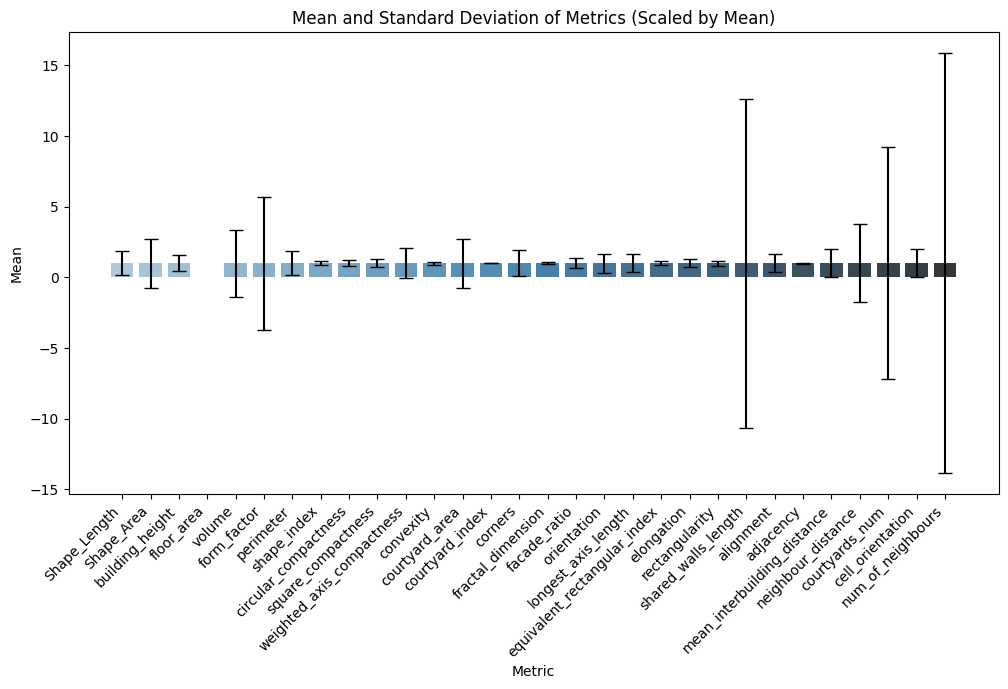

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns (excluding geometry) from buildings_cleaned
numeric_columns = buildings_cleaned.select_dtypes(include=['float64', 'int64'])

# Divide each metric by its mean
scaled_numeric_columns = numeric_columns.apply(lambda x: x / x.mean(), axis=0)

# Recalculate the mean and standard deviation after scaling
means_scaled = scaled_numeric_columns.mean()  # This should be 1 for all metrics
std_devs_scaled = scaled_numeric_columns.std()

# Create a DataFrame for plotting
metrics_summary_scaled = pd.DataFrame({
    'Metric': scaled_numeric_columns.columns,
    'Mean': means_scaled,
    'Standard Deviation': std_devs_scaled
})

# Plot the means (which should all be 1) with error bars representing the standard deviation
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Mean', data=metrics_summary_scaled, palette='Blues_d')

# Add error bars for standard deviation
plt.errorbar(x=range(len(metrics_summary_scaled)), y=metrics_summary_scaled['Mean'], 
             yerr=metrics_summary_scaled['Standard Deviation'], fmt='none', c='black', capsize=5)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Mean and Standard Deviation of Metrics (Scaled by Mean)')


C:\Users\david\AppData\Local\Temp\ipykernel_15052\2928025512.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Mean', data=metrics_summary_centralized, palette='Blues_d')


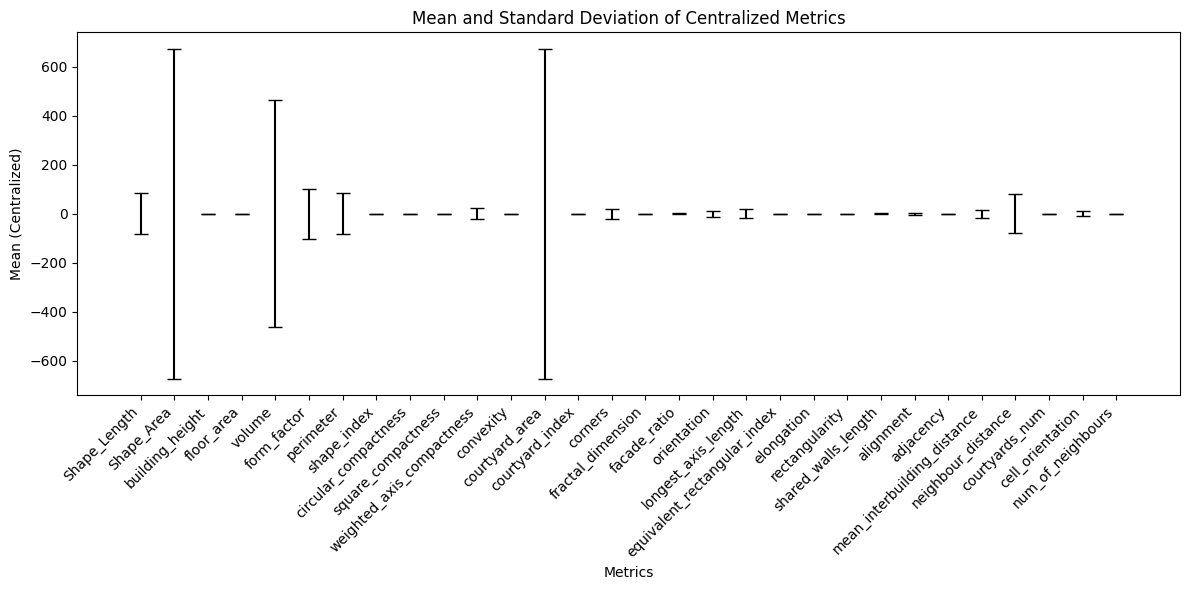

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns (excluding geometry) from buildings_cleaned
numeric_columns = buildings_cleaned.select_dtypes(include=['float64', 'int64'])

# Centralize the data by subtracting the mean from each column
centralized_numeric_columns = numeric_columns.apply(lambda x: x - x.mean(), axis=0)

# Recalculate the mean and standard deviation after centralization
means_centralized = centralized_numeric_columns.mean()  # This should be 0 for all metrics
std_devs_centralized = centralized_numeric_columns.std()

# Create a DataFrame for plotting
metrics_summary_centralized = pd.DataFrame({
    'Metric': centralized_numeric_columns.columns,
    'Mean': means_centralized,
    'Standard Deviation': std_devs_centralized
})

# Plot the means (which should all be 0) with error bars representing the standard deviation
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Mean', data=metrics_summary_centralized, palette='Blues_d')

# Add error bars for standard deviation
plt.errorbar(x=range(len(metrics_summary_centralized)), y=metrics_summary_centralized['Mean'], 
             yerr=metrics_summary_centralized['Standard Deviation'], fmt='none', c='black', capsize=5)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Mean and Standard Deviation of Centralized Metrics')
plt.xlabel('Metrics')
plt.ylabel('Mean (Centralized)')

plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_15052\4282492184.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Normalized Value', data=melted_normalized_data, palette='Blues_d')


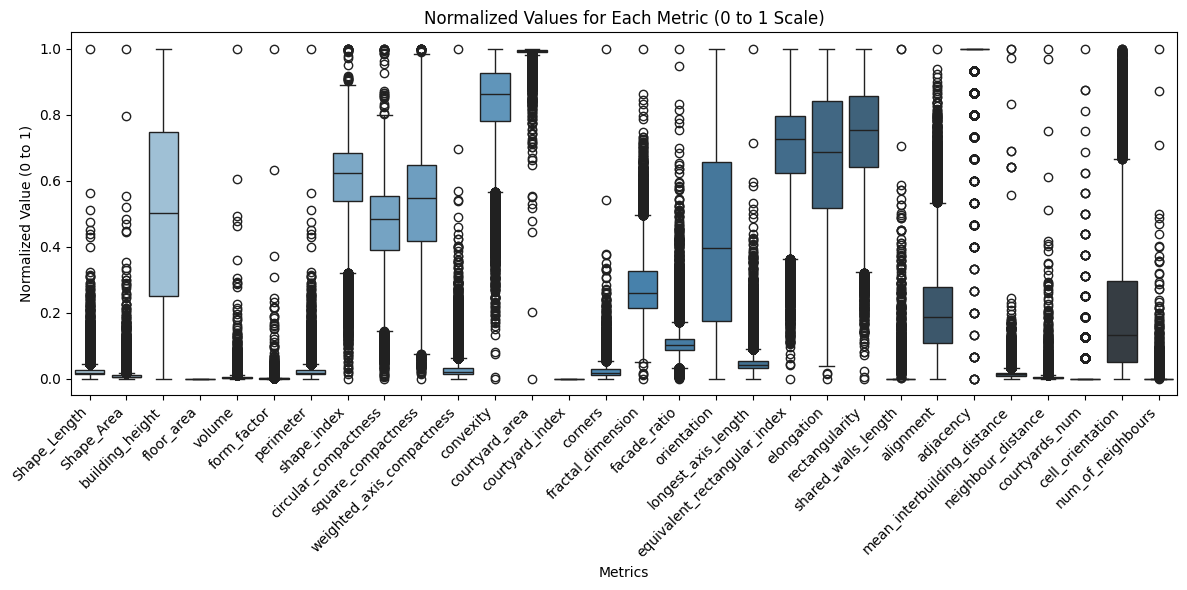

In [28]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns (excluding geometry) from buildings_cleaned
numeric_columns = buildings_cleaned.select_dtypes(include=['float64', 'int64'])

# Normalize the data using Min-Max scaling (range 0 to 1)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numeric_columns)

# Create a DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=numeric_columns.columns)

# Reshape the data using pd.melt() to create a long-format DataFrame for plotting
melted_normalized_data = pd.melt(normalized_df, var_name='Metric', value_name='Normalized Value')

# Plot the normalized values for each metric
plt.figure(figsize=(12, 6))
sns.boxplot(x='Metric', y='Normalized Value', data=melted_normalized_data, palette='Blues_d')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Normalized Values for Each Metric (0 to 1 Scale)')
plt.xlabel('Metrics')
plt.ylabel('Normalized Value (0 to 1)')

plt.tight_layout()
plt.show()


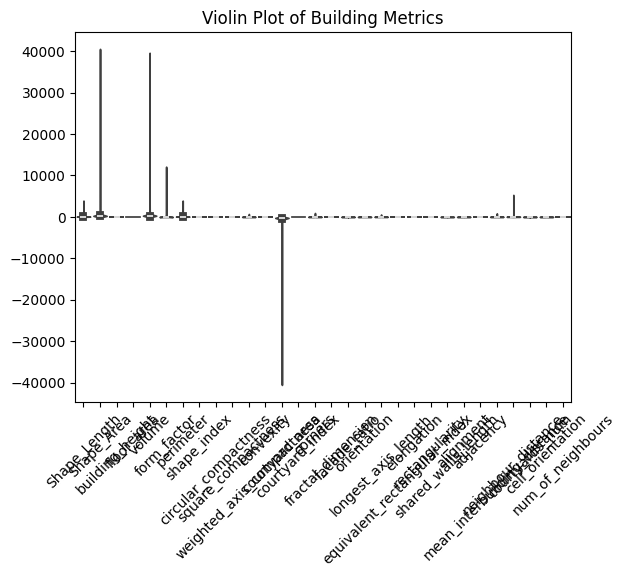

In [29]:
sns.violinplot(data=buildings_cleaned)
plt.xticks(rotation=45)
plt.title("Violin Plot of Building Metrics")
plt.show()

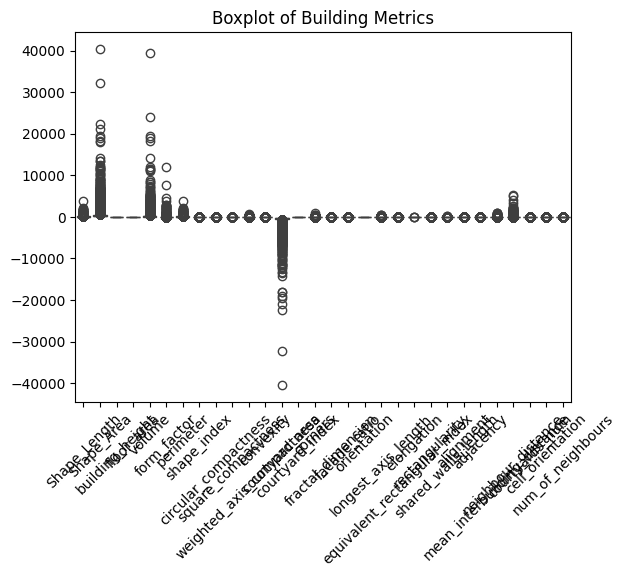

In [30]:
sns.boxplot(data=buildings_cleaned)
plt.xticks(rotation=45)
plt.title("Boxplot of Building Metrics")
plt.show()

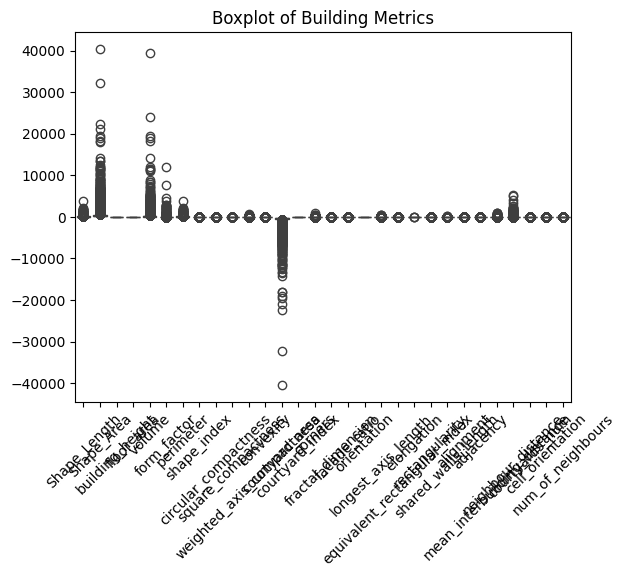

In [31]:
sns.boxplot(data=buildings_cleaned)
plt.xticks(rotation=45)
plt.title("Boxplot of Building Metrics")
plt.show()